In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import nnx
import time
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from functools import partial
from typing import Callable
from tqdm.auto import tqdm

# ==============================================================================
# 1. PARALLEL GRID MESH 
# ==============================================================================

MESH_CONFIG = "4x2"
EMULATE_DEVICES = False # Set to False for real multi-device hardware

def setup_mesh(mesh_config: str, emulate_devices: bool = False):
    data_size, model_size = map(int, mesh_config.split('x'))
    num_devices_required = data_size * model_size
    if emulate_devices:
        os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={num_devices_required}'
    device_count = jax.device_count()
    assert device_count == num_devices_required, (
        f"Mesh config '{mesh_config}' requires {num_devices_required}, but only {device_count} are available.")
    devices = np.array(jax.devices()).reshape(data_size, model_size)
    mesh = Mesh(devices, axis_names=('data', 'model'))
    print(f"Successfully detected {device_count} devices.")
    print(f"Created a mesh with shape (data, model) = ({data_size}, {model_size})")
    return mesh

mesh = setup_mesh(MESH_CONFIG, EMULATE_DEVICES)
P = PartitionSpec

# ==============================================================================
# 2. MODEL DEFINITION
# ==============================================================================
class SpectralConv1d(nnx.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int, *, rngs: nnx.Rngs):
        self.in_channels, self.out_channels, self.modes = in_channels, out_channels, modes
        key1, key2 = rngs.params(), rngs.params()
        scale = 1.0 / (self.in_channels * self.out_channels * self.modes)
        weight_init_fn = nnx.with_partitioning(
            lambda key, shape: jax.random.uniform(key, shape, minval=-scale, maxval=scale),
            P(None, 'model', None))
        self.real_weights = nnx.Param(weight_init_fn(key1, (self.in_channels, self.out_channels, self.modes)))
        self.imag_weights = nnx.Param(weight_init_fn(key2, (self.in_channels, self.out_channels, self.modes)))
    
    def complex_mult1d(self, x: jax.Array, y: jax.Array) -> jax.Array: 
        return jnp.einsum("bcM,coM->boM", x, y)
    
    def __call__(self, x: jax.Array):
        batch_size, _, spatial_points = x.shape
        x_hat = jnp.fft.rfft(x, axis=-1)
        x_hat_under_modes = x_hat[:, :, :self.modes]
        weights = self.real_weights.value + 1j * self.imag_weights.value
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)
        out_hat = jnp.zeros((batch_size, self.out_channels, x_hat.shape[-1]), dtype=jnp.complex64)
        out_hat = out_hat.at[:, :, :self.modes].set(out_hat_under_modes)
        return jnp.fft.irfft(out_hat, n=spatial_points, axis=-1)

class FNOBlock1d(nnx.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int, activation: Callable, *, rngs: nnx.Rngs):
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes, rngs=rngs)
        self.bypass_conv = nnx.Conv(in_features=in_channels, out_features=out_channels, kernel_size=(1,),
                                    kernel_init=nnx.with_partitioning(nnx.initializers.lecun_normal(), P(None, None, 'model')), rngs=rngs)
        self.activation = activation
    def __call__(self, x: jax.Array):
        x_transposed = x.transpose(0, 2, 1)
        bypass_out = self.bypass_conv(x_transposed).transpose(0, 2, 1)
        return self.activation(self.spectral_conv(x) + bypass_out)

class FNO1d(nnx.Module):
    def __init__(self, in_channels: int, out_channels: int, hidden_channels: int, modes: int, num_blocks: int, activation: Callable, *, rngs: nnx.Rngs):
        self.lifting_function = nnx.Conv(in_features=in_channels, out_features=hidden_channels, kernel_size=(1,),
                                         kernel_init=nnx.with_partitioning(nnx.initializers.lecun_normal(), P(None, None, 'model')), rngs=rngs)
        self.projection_function = nnx.Conv(in_features=hidden_channels, out_features=out_channels, kernel_size=(1,),
                                            kernel_init=nnx.with_partitioning(nnx.initializers.lecun_normal(), P(None, 'model', None)), rngs=rngs)
        self.fno_blocks = [FNOBlock1d(hidden_channels, hidden_channels, modes, activation, rngs=rngs) for _ in range(num_blocks)]
    def __call__(self, x: jax.Array):
        x = self.lifting_function(x).transpose(0, 2, 1)
        x = jax.lax.with_sharding_constraint(x, P('data', 'model', None))
        for block in self.fno_blocks: x = block(x)
        return self.projection_function(x.transpose(0, 2, 1))

def relu(x: jax.Array) -> jax.Array: return jax.nn.relu(x)


# ==============================================================================
# 3. SHARDED INITIALIZATION
# ==============================================================================
@partial(nnx.jit, static_argnames='model_factory')
def create_sharded_model(model_factory: Callable[[], nnx.Module]):
    model = model_factory()
    state = nnx.state(model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(model, sharded_state)
    return model


# This is the Python function we will call from inside the compiled JAX code.
def update_progress_bar(epoch_idx, current_loss):
    """Callback to update a global TQDM progress bar."""

    pbar.update(1)
    pbar.set_postfix(loss=f"{current_loss.item():.6f}")


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1757712016.118640      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Successfully detected 8 devices.
Created a mesh with shape (data, model) = (4, 2)


In [2]:
@partial(nnx.jit, static_argnames=('loss_fn', 'grad_fn', 'n_epochs'))
def train_with_callback_scan(
    optimizer: nnx.Optimizer,
    loss_fn: Callable,
    grad_fn: Callable,
    x_batched: jax.Array,
    y_batched: jax.Array,
    n_epochs: int
):
    optimizer_graphdef, optimizer_state_initial = nnx.split(optimizer)

    def epoch_scan_fn(opt_state_carry, epoch_idx):
        def batch_scan_fn(inner_opt_state_carry, batch):
            x, y = batch
            optimizer_temp = nnx.merge(optimizer_graphdef, inner_opt_state_carry)
            model_temp = optimizer_temp.model
            batch_loss, grads = grad_fn(model_temp, x, y)
            # jax.debug.print("loss {bar}", bar=batch_loss)
            optimizer_temp.update(grads)
            _, opt_state_new = nnx.split(optimizer_temp)
            return opt_state_new, batch_loss

        opt_state_final_for_epoch, batch_losses = jax.lax.scan(
            batch_scan_fn, opt_state_carry, (x_batched, y_batched))
        
        epoch_loss = jnp.mean(batch_losses)

        # Call the function that updated the tqdm bar from iniside the jitted function
        jax.experimental.io_callback(update_progress_bar, None, epoch_idx, epoch_loss)  
        
        return opt_state_final_for_epoch, epoch_loss

    epoch_indices = jnp.arange(n_epochs)
    opt_state_final, loss_history = jax.lax.scan(
        epoch_scan_fn, optimizer_state_initial, epoch_indices)
    
    final_optimizer = nnx.merge(optimizer_graphdef, opt_state_final)
    
    return final_optimizer, loss_history


In [3]:
# --- Hyperparameters ---
IN_CHANNELS = 2
OUT_CHANNELS = 2
HIDDEN_CHANNELS = 64
MODES = 16
NUM_BLOCKS = 3
SPATIAL_POINTS = 400
NUM_SAMPLES = 160
BATCH_SIZE = 16
EPOCHS = 500
LEARNING_RATE = 3*1e-4

# --- Create model and optimizer ---
print("Initializing the sharded FNO model...")
model_factory = lambda: FNO1d(
    in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, hidden_channels=HIDDEN_CHANNELS,
    modes=MODES, num_blocks=NUM_BLOCKS, activation=relu, rngs=nnx.Rngs(0))
with mesh:
    sharded_model = create_sharded_model(model_factory)
optimizer = nnx.Optimizer(sharded_model, optax.adam(LEARNING_RATE))


Initializing the sharded FNO model...


In [4]:
# --- Generate and prepare data ---
print("Generating and preparing dummy training data.")
key = jax.random.PRNGKey(42)
x_data = jax.random.normal(key, (NUM_SAMPLES, SPATIAL_POINTS, IN_CHANNELS))
y_data = jax.random.normal(key, (NUM_SAMPLES, SPATIAL_POINTS, OUT_CHANNELS))
n_batches = NUM_SAMPLES // BATCH_SIZE
x_batched = x_data[:n_batches * BATCH_SIZE].reshape(n_batches, BATCH_SIZE, SPATIAL_POINTS, IN_CHANNELS)
y_batched = y_data[:n_batches * BATCH_SIZE].reshape(n_batches, BATCH_SIZE, SPATIAL_POINTS, OUT_CHANNELS)

def loss_fn(model: FNO1d, x: jax.Array, y: jax.Array):
    y_pred = model(x)
    # jax.debug.print("y {x}", x=y.shape)
    # jax.debug.print("y_pred {x}", x=y_pred.shape)
    y1=jnp.mean((y_pred - y) ** 2)
    # jax.debug.print("y1 {x}", x=y1.shape)
    return y1
grad_fn = nnx.value_and_grad(loss_fn)

dataset_sharding = NamedSharding(mesh, P(None, 'data', None, None))

with mesh:
    x_batched_sharded = jax.device_put(x_batched, dataset_sharding)
    y_batched_sharded = jax.device_put(y_batched, dataset_sharding)


print("Starting JIT compilation and training...")

pbar = tqdm(total=EPOCHS, desc="Training Progress")
time1=time.time()
try:
    with mesh:
        final_optimizer, loss_history = train_with_callback_scan(
            optimizer, loss_fn, grad_fn,
            x_batched_sharded, y_batched_sharded,
            n_epochs=EPOCHS
        )

        loss_history.block_until_ready()
finally:
    pbar.close()
time2=time.time()
print(time2-time1)
print("Training finished successfully!")



Generating and preparing dummy training data for scan...

Starting JIT compilation and training...


Training Progress: 100%|██████████| 500/500 [00:09<00:00, 54.31it/s, loss=0.000019] 


9.20828628540039

Training finished successfully!


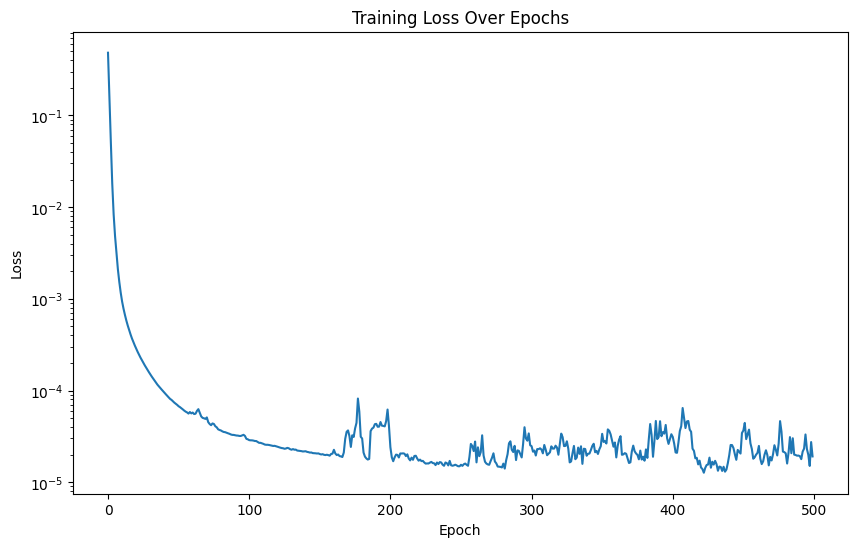

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()